# IP 3: Predicting production and attraction of zones based on POI's and population density with an xgBoost model



In [ ]:
# Install the packages that are not yet installed of the next block of code
# pip install xgboost
# pip install ...

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import xgboost as xgb
import shap
import seaborn as sns

## Read files

The following datasets are required in this file:
1) combined_data_ALL_TRAIN.shp: training dataset generated with file 'combine_data'
2) combined_data_ALL_TEST.shp: test dataset generated with file 'combine_data'
3) ZONERING_spm_VLA.shp : zonering of MOW 

 They have the following characteristics:
- The train data have in total 193 zones from the city of 'ANTWERPEN'. 
- The test data have in total 217 zones from the cities 'GENT', 'DENDERMONDE', 'BEVEREN' and 'HASSELT'.

In [3]:
setup_params = {'user': 'L', 'target': 'production', 'logtrans': 1, 'outlier': 0, 'CV': 1}

# User: choose the user. This will make sure the right directory is chosen to load and read files: 'E' or 'L'  ('E': Emma & 'L': Laurens)
# logtrans: do you want to apply a logarithmic transformation? 1 for yes, 0 for no
# outlier: want to perform outlier detection? 1 for yes, 0 for no
# CV = Cross validation: do you want to select hyperparameters based on cross validation or standard parameters for XGBoost? 1 for yes, 0 for no

In [4]:
name_model = "prod_small_model.json"                     # The name with which the model will be saved
name_excel_file_metrics = "Metrics_PROD_small_model"     # The name of the excel file in which a summary of the metrics wiil be stored   

In [5]:
#Load in correct files
if setup_params['user'] == 'L': # directories of Laurens
    data_train = gpd.read_file('combined_data\Data_combined\combined_data_ALL_TRAIN.shp')
    data_test = gpd.read_file('combined_data\Data_combined\combined_data_ALL_TEST.shp')
    zones_city = gpd.read_file("OneDrive_2024-03-21\IP3 Emma en Laurens\ZONERING_spm_VLA.shp")  #load in zones of vlaanderen of the MOW data
    print("Laurens")

elif setup_params['user'] == 'E': # directories of Emma
    data_train = gpd.read_file('Data_combined\combined_data_ALL_TRAIN.shp')
    data_test = gpd.read_file('Data_combined\combined_data_ALL_TEST.shp')
    zones_city = gpd.read_file("ZONERING_spm_VLA\ZONERING_spm_VLA.shp")
    print("Emma")


Laurens


## Combined dataset

Summary of the information in the combined dataset:

An important part of this project is the creation of a dataset. The dataset used includes the production and attraction of displacements between 7am and 8am for each zone, the POI information and population information for each zone. For each zone, the POIs are classified into one of the following categories: large_resi, small_resi, School, Health, Leisure, Shops, Services, Industry, Catering_i, Tourism, leisure_ar and Other. In addition, each zone has a zone number and the geometry of a zone is stored by means of a polygon. In addition, the number of inhabitants and population density is also known (calculation see file "Density_inw_per_ha"). The name of the city where the zone is located is also explicitly given. Finally, the size of the city is added, giving an estimate of approximately how many inhabitants live in the city. This can be used as information for the model and shows to which category the city has been counted.

In [6]:
data_train = data_train[data_train['city'] == 'ANTWERPEN']

In [7]:
# Shows how the dataframe 
data_train.head()

,ZONENUMMER,inhabitant,density,city,city_size,production,attraction,large_resi,small_resi,School,Health,Leisure,Shops,Services,Industry,Catering_i,Tourism,Others,Leisure_ar,geometry
0,8,2852.592124,10338.533007,ANTWERPEN,500000,591.711,809.713,78568.365178,2629.949173,3240.647711,128.442093,1148.359176,5944.020433,5759.299732,0.0,13115.489042,5320.593807,4607.435937,439.452869,"POLYGON ((151886.893 212393.727, 151896.819 21..."
1,9,1663.206665,12061.589962,ANTWERPEN,500000,377.687,1077.690,54593.025088,11163.096491,0.000000,513.009998,399.359237,2160.485684,7866.468777,0.0,2653.671133,408.952544,0.000000,0.000000,"POLYGON ((152291.417 213076.701, 152323.130 21..."
2,10,540.996256,4973.824681,ANTWERPEN,500000,233.434,1331.431,37052.473093,200.381735,2361.870653,556.902082,631.059088,19381.985231,3327.157104,0.0,7229.002237,348.766092,7445.807094,0.000000,"POLYGON ((152554.784 212236.842, 152554.655 21..."
3,11,1118.253264,12097.422044,ANTWERPEN,500000,264.410,230.412,37097.357794,628.217699,0.000000,109.942887,921.972837,8507.389210,1569.489492,0.0,12445.166200,2814.945431,0.000000,363.209287,"POLYGON ((151952.251 212369.105, 152001.366 21..."
4,12,1353.762508,9070.177277,ANTWERPEN,500000,355.119,1851.122,46076.192553,910.223994,11400.031400,307.276028,3009.474225,17572.225446,10773.263095,0.0,3064.863207,354.988740,4123.672896,332.580263,"POLYGON ((152461.194 211945.115, 152467.897 21..."


In [8]:
# Overvieuw of the data 
data_train.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 193 entries, 0 to 192
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ZONENUMMER  193 non-null    object  
 1   inhabitant  193 non-null    float64 
 2   density     193 non-null    float64 
 3   city        193 non-null    object  
 4   city_size   193 non-null    int64   
 5   production  193 non-null    float64 
 6   attraction  193 non-null    float64 
 7   large_resi  193 non-null    float64 
 8   small_resi  193 non-null    float64 
 9   School      193 non-null    float64 
 10  Health      193 non-null    float64 
 11  Leisure     193 non-null    float64 
 12  Shops       193 non-null    float64 
 13  Services    193 non-null    float64 
 14  Industry    193 non-null    float64 
 15  Catering_i  193 non-null    float64 
 16  Tourism     193 non-null    float64 
 17  Others      193 non-null    float64 
 18  Leisure_ar  193 non-null    float64 
 19  

In [9]:
# Gives an insight into the values of the numeric columns
data_train.describe()

# Note that some of the categories of the POIs have over 50% of zeros.

,inhabitant,density,city_size,production,attraction,large_resi,small_resi,School,Health,Leisure,Shops,Services,Industry,Catering_i,Tourism,Others,Leisure_ar
count,193.000000,193.000000,193.0,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,1.930000e+02
mean,2686.651997,7075.350665,500000.0,559.502166,671.201746,25105.338035,43824.622632,3537.041619,1360.168770,1883.416164,4989.504688,3742.045714,9499.320126,1112.175077,660.375486,819.159737,5.454023e+04
std,2208.313836,6583.836039,0.0,456.780468,541.618238,39615.334629,59049.779342,6091.656184,3656.648726,4704.208417,9395.277150,6148.693934,37012.859175,2069.374473,2013.349233,1771.373323,1.787480e+05
min,0.000000,0.000000,500000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,427.022433,671.593515,500000.0,108.037000,203.492000,0.000000,138.893466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,2428.645122,6141.914569,500000.0,537.090000,554.845000,1524.787810,4174.716186,1410.294867,142.609778,191.433307,1945.961216,866.204284,0.000000,312.906169,0.000000,0.000000,1.664999e+03
75%,4367.002662,11219.669361,500000.0,877.811000,1033.104000,37271.177256,85063.928204,4801.834964,756.026551,1510.006413,6323.855530,5100.337185,418.009253,1139.175937,209.292301,1264.127690,2.580218e+04
max,8106.342111,24408.190046,500000.0,2029.289000,3338.480000,166332.504250,232766.052055,44900.671729,26017.265470,40384.007551,81972.336248,32097.316653,279850.021282,13115.489042,19529.619899,19119.617359,1.561546e+06


In [10]:
# Shows the cities used in the training set
data_train['city'].unique() 

array(['ANTWERPEN'], dtype=object)

In [11]:
# Shows what the dataframe 
data_test.head()

,ZONENUMMER,inhabitant,density,city,city_size,production,attraction,large_resi,small_resi,School,Health,Leisure,Shops,Services,Industry,Catering_i,Tourism,Others,Leisure_ar,geometry
0,2467,804.273060,3954.691868,GENT,270000,252.865,965.871,3682.170215,50511.095518,7132.437994,166.118609,3909.543358,16250.966143,14390.828625,0.000000,17049.292734,6532.082039,10895.960539,3465.859923,"POLYGON ((105184.260 193832.897, 105175.236 19..."
1,2468,2717.092743,8733.092072,GENT,270000,770.022,1595.021,7514.938419,117408.020203,13887.516715,598.349485,2944.023268,9283.314743,20233.002534,1987.422401,8153.527634,3275.916877,1435.731971,19413.533645,"POLYGON ((105410.629 194259.208, 105429.192 19..."
2,2469,1147.842147,4772.002629,GENT,270000,531.773,2015.771,24719.747133,38110.237909,7342.780263,221.602732,4094.486782,35844.719439,20704.937687,0.000000,10505.158643,3981.695294,500.949986,0.000000,"POLYGON ((105094.151 193691.739, 105073.654 19..."
3,2470,879.090943,8459.200304,GENT,270000,245.520,170.511,7645.839036,35345.222585,0.000000,346.997186,92.178082,1662.331753,1498.794963,0.000000,7764.661214,4133.462087,0.000000,1879.121492,"POLYGON ((104839.808 194650.326, 104838.648 19..."
4,2471,2332.238767,6067.689094,GENT,270000,500.952,1263.949,16358.827533,44831.573405,4927.202098,39243.558808,4388.634171,2738.776977,11399.718562,7477.079249,704.467549,3080.305046,6771.232255,48218.319956,"POLYGON ((104839.808 194650.326, 104771.356 19..."


In [12]:
# Overvieuw of the data 
data_test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ZONENUMMER  217 non-null    object  
 1   inhabitant  217 non-null    float64 
 2   density     217 non-null    float64 
 3   city        217 non-null    object  
 4   city_size   217 non-null    int64   
 5   production  217 non-null    float64 
 6   attraction  217 non-null    float64 
 7   large_resi  217 non-null    float64 
 8   small_resi  217 non-null    float64 
 9   School      217 non-null    float64 
 10  Health      217 non-null    float64 
 11  Leisure     217 non-null    float64 
 12  Shops       217 non-null    float64 
 13  Services    217 non-null    float64 
 14  Industry    217 non-null    float64 
 15  Catering_i  217 non-null    float64 
 16  Tourism     217 non-null    float64 
 17  Others      217 non-null    float64 
 18  Leisure_ar  217 non-null    float64 
 19  

In [13]:
# Gives an insight into the values of the numeric columns
data_test.describe()

# Note that some of the categories of the POIs have over 50% of zeros.

,inhabitant,density,city_size,production,attraction,large_resi,small_resi,School,Health,Leisure,Shops,Services,Industry,Catering_i,Tourism,Others,Leisure_ar
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,2.170000e+02
mean,1953.542940,2434.417987,172442.396313,450.723673,564.986295,7910.219880,85883.262174,5250.610277,2245.362899,2420.375053,6878.185787,7249.584748,40319.855500,1175.746844,1005.609342,679.377192,5.513200e+04
std,1907.843117,3116.393799,105246.745572,460.251155,636.503094,14824.863494,94728.885707,9501.797318,7343.163112,5435.821515,10655.710089,10759.150632,96858.210088,2168.026294,3967.132228,1300.220925,1.285242e+05
min,0.000000,0.000000,50000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,104.233716,84.999214,50000.000000,31.479000,88.117000,0.000000,3300.067507,0.000000,0.000000,0.000000,0.000000,146.625383,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,1478.589540,711.354042,270000.000000,329.749000,360.844000,1525.927271,54024.115408,1465.809542,114.619606,449.937000,2439.071020,3563.523622,2199.457617,357.164869,0.000000,0.000000,1.229601e+04
75%,3165.949338,4325.915397,270000.000000,734.916000,827.636000,7976.153658,127391.866379,6111.688037,1448.978119,3048.112899,8732.308170,10594.206951,21720.013717,1385.276613,448.520813,888.825144,5.606886e+04
max,8066.505314,17290.251960,270000.000000,2385.412000,4339.417000,105282.658123,438684.848324,67178.288971,84135.815336,53943.654883,69801.906357,88293.414112,618122.769860,17049.292734,51891.023282,10895.960539,1.336151e+06


In [14]:
# Shows the cities used in the training set
data_test['city'].unique() 

array(['GENT', 'DENDERMONDE', 'BEVEREN', 'HASSELT'], dtype=object)

# Preprocessing

## Split train/validation/test data

Firstly the target variable is split from the features. Later 20% of the training set is separated and will be used as a validation set. 

In [15]:
# Get the 2 target variables out of the dataframe

# Training set
y_train = data_train[setup_params['target']]
X_train = data_train.drop(columns=['production', 'attraction'])

# Test set
y_test = data_test[setup_params['target']]
X_test = data_test.drop(columns=['production', 'attraction'])

In [16]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80%/20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Copy the full datasets that havsn't been preprocessed. This will be used later to be able to use the data from the deleted columns when interpreting.
X_train_with_all_columns = X_train.copy()
X_val_with_all_columns = X_val.copy()
X_test_with_all_columns = X_test.copy()

In [17]:
# Drop the features that do not provide valuable information for the predictive model

# Drop the columns from the train DataFrame
X_train.drop(columns=['ZONENUMMER'], inplace=True)
X_train.drop(columns=['geometry'], inplace=True)
X_train.drop(columns=['city'], inplace=True)

# Drop the columns from the validation DataFrame
X_val.drop(columns=['ZONENUMMER'], inplace=True)
X_val.drop(columns=['geometry'], inplace=True)
X_val.drop(columns=['city'], inplace=True)

# Drop the columns from the test DataFrame
X_test.drop(columns=['ZONENUMMER'], inplace=True)
X_test.drop(columns=['geometry'], inplace=True)
X_test.drop(columns=['city'], inplace=True)

## Feature selection

This paragraph will do feature selection based on the correlation matrix of the training dataset and the mutual information between the features and the target variable.


Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior


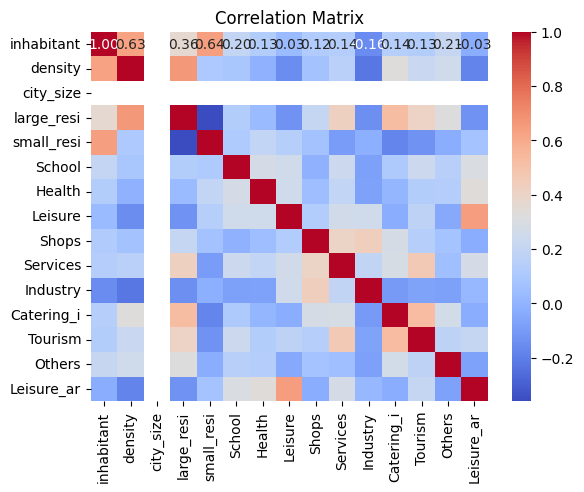

In [18]:
# Check correlation matrix
correlation_matrix = X_train.corr()

# Visualize the correlation matrix
plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [19]:
#check for pairs with a high correlation
corr_treshold = 0.5 #set correlation treshold at 0.5

high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > corr_treshold: 
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], str(int(100*abs(correlation_matrix.iloc[i, j])))+'%'))
            

print(high_correlation_pairs)
# High correlation between density & large_res --> drop large_res

[('inhabitant', 'density', '63%'), ('inhabitant', 'small_resi', '63%'), ('density', 'large_resi', '66%'), ('large_resi', 'Catering_i', '52%'), ('Leisure', 'Leisure_ar', '64%'), ('Catering_i', 'Tourism', '52%')]


The correlation matrix shows 6 pairs with a correlation higher than 50%. However, for this project we want to feed the model data that is preprocessed in the same way. That's why only Large_resi will be dropped. The biggest correlation pair and the feature with the lowest mutual info is still eliminated.


In [20]:
from sklearn.feature_selection import mutual_info_regression

# Calculate the mutual info between the target variable 
mutual_info = mutual_info_regression(X_train, y_train)

# Display mutual information scores for each feature
for i, col in enumerate(X_train):  # Exclude the target variable
    print(f"Mutual Information with '{col}': {mutual_info[i]}")

Mutual Information with 'inhabitant': 1.5074291669791156
Mutual Information with 'density': 0.6164226960055443
Mutual Information with 'city_size': 0.010685270098178878
Mutual Information with 'large_resi': 0.4337803319174798
Mutual Information with 'small_resi': 0.6006139371581565
Mutual Information with 'School': 0.2377803129524927
Mutual Information with 'Health': 0.13463939121903645
Mutual Information with 'Leisure': 0.12719880351033552
Mutual Information with 'Shops': 0.2182885564767063
Mutual Information with 'Services': 0.2283372193249531
Mutual Information with 'Industry': 0.04752757446985867
Mutual Information with 'Catering_i': 0.21604380455299577
Mutual Information with 'Tourism': 0.020416272235913357
Mutual Information with 'Others': 0.18715629333241912
Mutual Information with 'Leisure_ar': 0.16433666065928154


Density and inhabitant have a high mutual information of 0.66 towards each other. Like said before, both features will remain to have the same pipeline over all the models.

In [21]:

mutual_info = mutual_info_regression(X_train['density'].values.reshape(-1, 1), X_train['inhabitant'].values)
print(mutual_info)

mutual_info = mutual_info_regression(X_train['inhabitant'].values.reshape(-1, 1), X_train['density'].values)
print(mutual_info)

# mutual_info = mutual_info_regression(X_train, X_train['density'].values)
# Display mutual information scores for each feature
# for i, col in enumerate(X_train):  # Exclude the target variable
#    print(f"Mutual Information with '{col}': {mutual_info[i]}")

[0.66636959]
[0.65625125]


In [22]:
# Drop large_res based on correlation and lower mutual information. Don't drop inhabitant as it has high mutual information.
X_train = X_train.drop(columns=['large_resi', 'city_size'])
X_val = X_val.drop(columns=['large_resi', 'city_size'])
X_test = X_test.drop(columns=['large_resi', 'city_size'])

## Log transfromation

As seen on the histogram below the POI data is very imbalanced and always right-skewed. To improve the data quality a log transformation will be applied. This transformation is used because the POI data is always non-negative and it leads to a more normal distribution for the features. Most of the zones have either 0 or a very low value for a POI feature. The log transformation will try to balance the data and get to a normal distribution for the number of POI's throughout the zones. To avoid log(0) a constant is added. 
Later on, the predictions will be backtransformed to make sure they are interpretable.

array([[<Axes: title={'center': 'inhabitant'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'small_resi'}>,
        <Axes: title={'center': 'School'}>],
       [<Axes: title={'center': 'Health'}>,
        <Axes: title={'center': 'Leisure'}>,
        <Axes: title={'center': 'Shops'}>,
        <Axes: title={'center': 'Services'}>],
       [<Axes: title={'center': 'Industry'}>,
        <Axes: title={'center': 'Catering_i'}>,
        <Axes: title={'center': 'Tourism'}>,
        <Axes: title={'center': 'Others'}>],
       [<Axes: title={'center': 'Leisure_ar'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

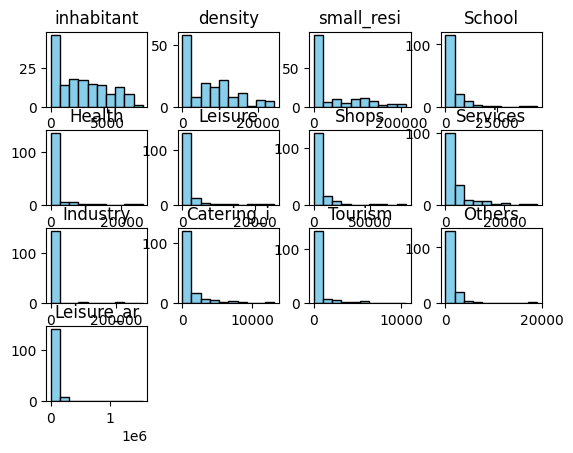

In [23]:
# Show the distribution of the untransformed variables
X_train.hist(color='skyblue', edgecolor='black', grid=False)

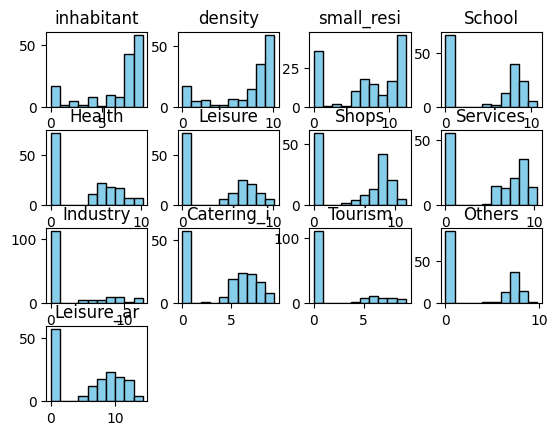

In [24]:
## apply log transformation
if setup_params['logtrans'] == 1:
    X_train = X_train.apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0)
    X_val = X_val.apply(lambda x: np.log(x + 1))  
    X_test = X_test.apply(lambda x: np.log(x + 1))  
    X_train.hist(color='skyblue', edgecolor='black', grid=False) # Show the distribution of the Logtransformed variables
    
    y_train = y_train.apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0)
    y_val = y_val.apply(lambda x: np.log(x + 1)) 

else:
    print("no log transfromation has been done")

## Outlier detection

The following paragraph creates boxplots for the numerical features. It shows that for the POI features no outliers are found. Inhabitant and density have outliers. This is a consequence of the log transformation. Because of the strong transformation the right skewed data became left skewed. However these outliers won't be taken out for two reasons: Firstly, our dataset is very limited. Secondly, both features were added later on and are perfectly valid instances. It can be interesting to see how the model handles these instances. 

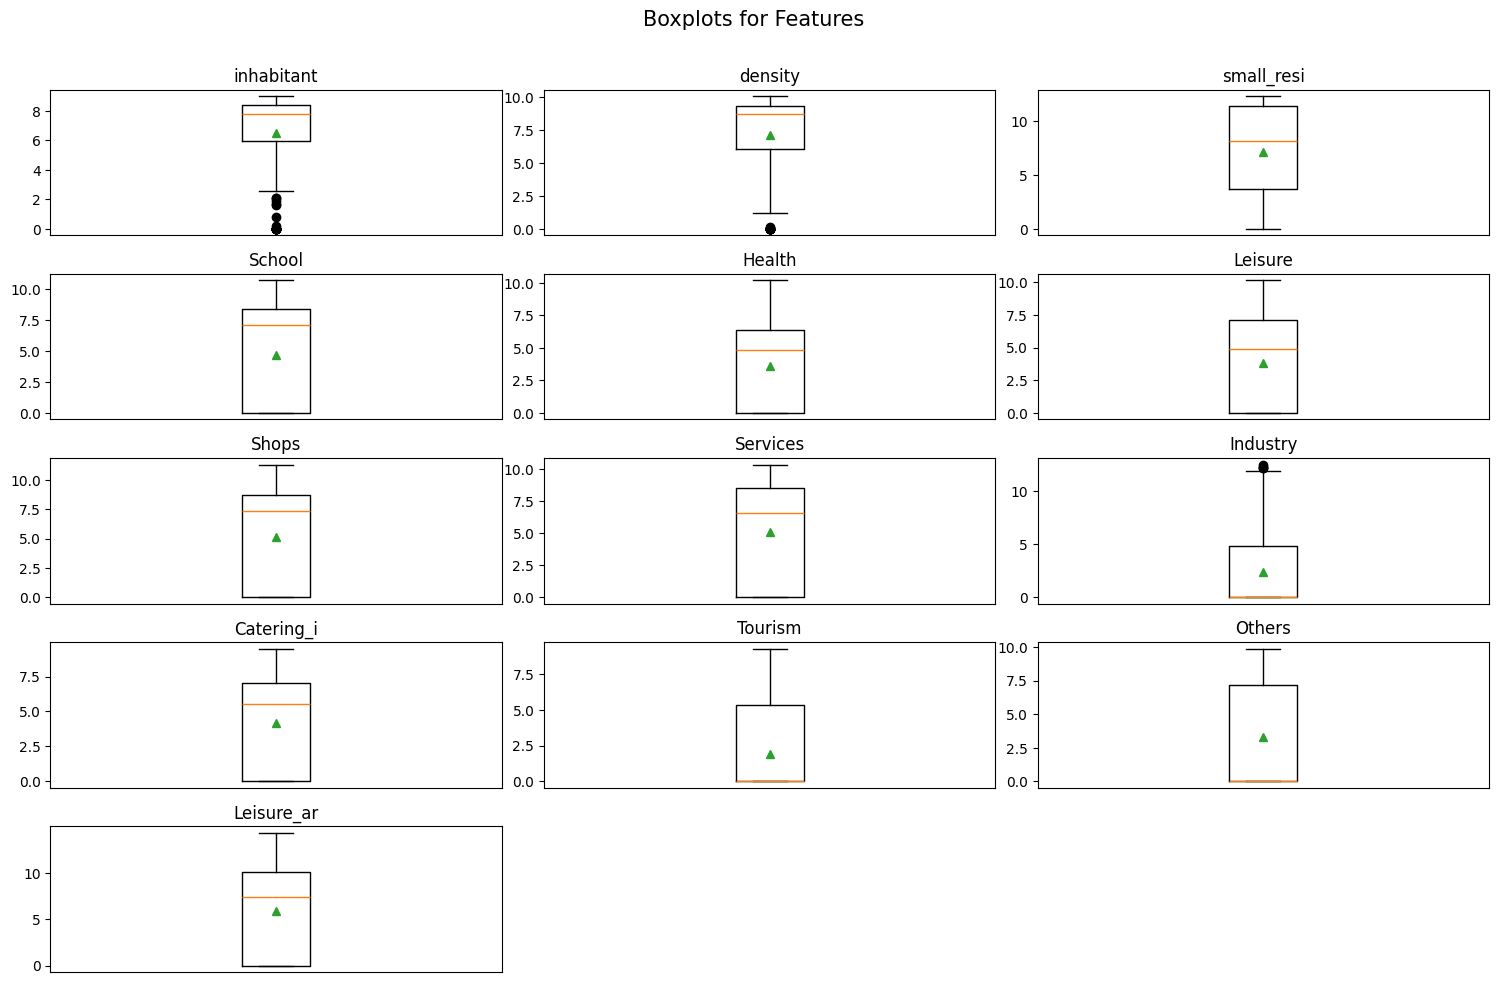

In [25]:
num_features = len(X_train.columns)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols
flierprops = dict(marker='o', markerfacecolor='black')

# create the figures
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
fig.suptitle("Boxplots for Features", fontsize=15)

# flatten the axes array to easily iterate through the subplots
axes = axes.flatten()

for i, feature in enumerate(X_train.columns):
    ax = axes[i]
    ax.boxplot(X_train[feature], showmeans=True, flierprops=flierprops)
    ax.set_title(feature)
    ax.get_xaxis().set_visible(False)

# hide subplots not being used
for i in range(len(X_train.columns), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Metrics overview function

Here two functions are defined to evaluate the models that are created later. The following metrics are used: true mean, pred_mean, bias, MAE, MSE, RMSE, MAPE, uncentered R^2.
The MAPE gives very high values because of small true values or when the absolute value of the difference between the true and the predicted value is large.


In [26]:
def uncentered_r2_score(true, pred):
    SS_res = np.sum((true - pred) ** 2)
    SS_tot = np.sum((true - np.mean(true)) ** 2)
    return 1 - (SS_res / SS_tot)

In [27]:
def metrics_overview(true_value, predicted_value, printing = True):
    
    metrics_all = []

    added_df = pd.DataFrame()
    added_df['predicted'] = list(predicted_value)
    added_df['value'] = list(true_value)
    
    total = added_df['value'].sum()

    intervals = [(0,250),(250,500),(500,750), (750,1000), (1000,1250),(1250,1500), (1500,2250), (0,2500)]

    for interval_start, interval_end in intervals:
        interval = (interval_start, interval_end)
        interval_df = added_df[(added_df['value'] >= interval_start) & (added_df['value'] < interval_end)]

        if not interval_df.empty:
            true = interval_df['value']
            pred = interval_df['predicted']
            
            nr_zones = true.shape[0] 
            percentage_of_total = true.sum()/total
            true_mean = np.mean(true)
            pred_mean = np.mean(pred)
            bias = pred_mean - true_mean
            MAE = metrics.mean_absolute_error(true, pred)
            MSE = metrics.mean_squared_error(true, pred)
            RMSE = np.sqrt(metrics.mean_squared_error(true, pred))
            MAPE = metrics.mean_absolute_percentage_error(true, pred) #can be very high because of small true or when abs(true -  pred) is large
            uncentered_r2 = uncentered_r2_score(true, pred) #metrics.r2_score(true, pred)
        
        else:   #empty inteval_df
            nr_zones = 0
            percentage_of_total = 0
            true_mean = 0
            pred_mean = 0
            bias = 0
            MAE = 0
            MSE = 0
            RMSE = 0
            MAPE = 0
            uncentered_r2 = 0


        if setup_params['target'] == 'attraction':
            percentage_total_name = 'percentage of total attraction: '
        elif setup_params['target'] == 'production':
            percentage_total_name = 'percentage of total production: '
    
        if printing:
            print('interval: ', interval, ' number of zones: ', nr_zones, percentage_total_name, percentage_of_total)
            print('True mean: ', true_mean, 'Predicted Mean: ', pred_mean, 'Bias: ',bias)
            print('Mean Absolute Error:', MAE)
            print('Mean Squared Error:', MSE)
            print('Root Mean Squared Error:', RMSE)
            print('Mean absolute Percentage Error:' , MAPE)
            print('R2 score: ', uncentered_r2)

        
        
        metrics_all.append({'interval' : interval, 'nr of zones': nr_zones, percentage_total_name : percentage_of_total, 
                        'true mean': true_mean, 'pred mean': pred_mean, 'bias': bias, 'MAE' : MAE, 'MSE': MSE, 'RMSE':RMSE , 'MAPE' : MAPE, 'R2' : uncentered_r2} )

    df_metrics = pd.DataFrame(metrics_all)

    return df_metrics
        

## Function write metrics results to excel

Below is the function that will write the results of the metrics to an excel file.

In [28]:
def write_metrics_overviews_to_excel(name_excel_file, sheet_name, dfs, titles):
    
    # Create an ExcelWriter object
    with pd.ExcelWriter(name_excel_file, engine='xlsxwriter') as writer:

        # Add a worksheet
        writer.book.add_worksheet(sheet_name)

        row = 0
        for df, title in zip(dfs, titles):
            # Write the title
            writer.sheets[sheet_name].write(row, 0, title)
            row += 1
            
            # Write a white line (empty row)
            row += 1
            
            # Write the DataFrame
            df.to_excel(writer, sheet_name=sheet_name, startrow=row, index=False)
            row += len(df) + 2  # Move row pointer to the next position for the next df


# Model

Now the model can be constructed. The model will be made with the XGboost package. This package is the most efficient one for tabular data. XGboost uses an extreme gradient boosting framework. 
<br>
Firstly a regressor model is initialized. Then the hyperparameters are tuned through a 5-fold cross validation. These can also be tuned to avoid overfitting. The model is trained on the preprocessed training data.

## Model

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 0.4, 'learning_rate': 0.2, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 40, 'subsample': 0.7}
Best Score (MSE): 0.3729351314490341
Test MSE: 0.25737642941274486


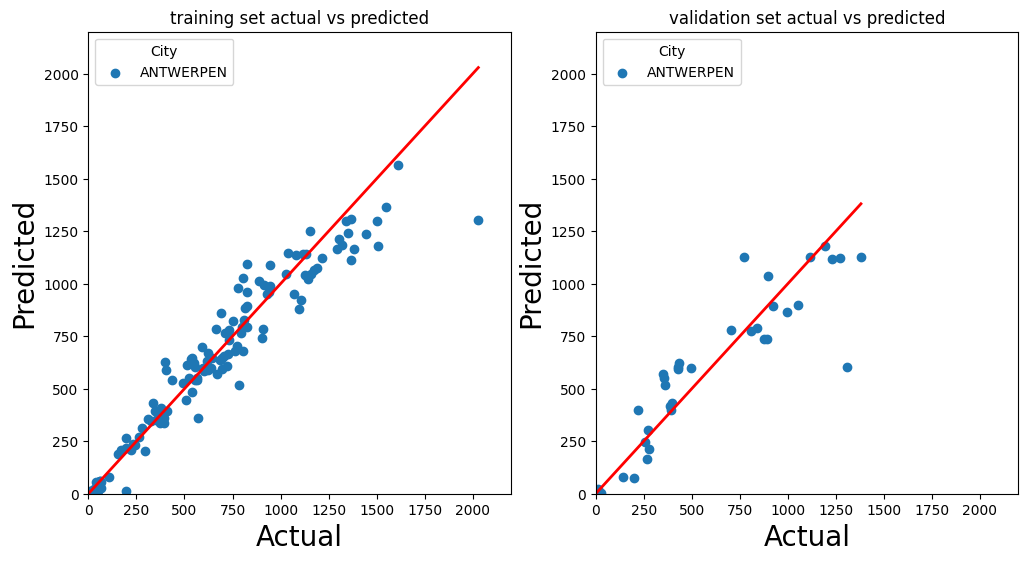

In [29]:
## Training and Validation

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse') #training loss is based on the squared error of the loss, the evaluation metric of the validation set is rmse

#CROSS VALIDATION
if setup_params['CV'] == 0:
    model = xgb.XGBRegressor(colsample_bytree= 0.4, learning_rate= 0.1, max_depth=4, min_child_weight=6, n_estimators= 40, subsample= 0.7) 
    model.fit(X_train, y_train)

elif setup_params['CV'] == 1:
    param_grid = {
        'max_depth': [2, 3, 4],
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [30, 40, 50],
        'min_child_weight': [4, 5, 6],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.4, 0.5, 0.6],
        # 'reg_alpha': [0.05, 0.075, 0.1], regularization doesnt seem to help
        # 'reg_lambda' : [0.05, 0.075, 0.1]
    }

    # Initialize GridSearchCV with the defined parameter grid and XGBoost model, the scoring function wants to maximize so negative MSE is chosen
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

    # Perform GridSearchCV
    grid_search.fit(X_train, y_train)

    # Get the best parameters and the best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Score (MSE):", -best_score)

    # Evaluate the model on the validation data
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    mse = metrics.mean_squared_error(y_val, y_pred)
    print("Test MSE:", mse)


best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)
model = best_xgb_model

model.save_model(name_model)


# get predictions on training set
y_pred_train = pd.DataFrame(model.predict(X_train))

# get predictions on validation set
y_pred_val = pd.DataFrame(model.predict(X_val))

# Backtransform
if setup_params['logtrans'] == 1:
    X_train = X_train.apply(lambda x: np.exp(x)-1)  # Adding 1 to avoid log(0)
    X_val = X_val.apply(lambda x: np.exp(x)-1)  # Adding 1 to avoid log(0)

    y_train = y_train.apply(lambda x: np.exp(x)-1)  # Adding 1 to avoid log(0)
    y_val = y_val.apply(lambda x: np.exp(x)-1)  # Adding 1 to avoid log(0)

    y_pred_train = y_pred_train.apply(lambda x: np.exp(x)-1)
    y_pred_val = y_pred_val.apply(lambda x: np.exp(x)-1)
else:
    print("no log transfromation has been done")


# Training plot
cities = X_train_with_all_columns['city'].unique()
city_to_color = {city: plt.cm.tab20(i) for i, city in enumerate(cities)}  # Using tab20 colormap for distinct colors

plt.figure(figsize=(12, 6))

# Scatter plot with colors based on city
plt.subplot(1, 2, 1)
for city in cities:
    mask = X_train_with_all_columns['city'] == city
    y_train_city = y_train[mask.to_numpy()]
    y_pred_train_city = y_pred_train[mask.to_numpy()]
    plt.scatter(y_train_city, y_pred_train_city, label=city, color=city_to_color[city])

plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color="r", linestyle="-", linewidth=2)
plt.title("training set actual vs predicted")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.xlim(0, 2200)  # Set x-axis limit
plt.ylim(0, 2200)  # Set y-axis limit
plt.legend(title='City', loc='upper left')


# Validation plot

plt.subplot(1, 2, 2)
for city in cities:
    mask = X_val_with_all_columns['city'] == city
    y_val_city = y_val[mask.to_numpy()]
    y_pred_val_city = y_pred_val[mask.to_numpy()]
    plt.scatter(y_val_city, y_pred_val_city, label=city, color=city_to_color[city])

plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="r", linestyle="-", linewidth=2)
plt.title("validation set actual vs predicted")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.xlim(0, 2200)  # Set x-axis limit
plt.ylim(0, 2200)  # Set y-axis limit
plt.legend(title='City', loc='upper left')

plt.show()

The graphs above show the predictions of the training set and the validation set.  These graphs show a decent fit until the true values are higher than 1500, then the model continuously underestimates the number of trips. 


In the graph below the axis are limited to 500. This allows to check the predictions for zones with a low number of trips. Compared to the attraction model: this model doesn't show a predicted value that comes back repeatedly

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


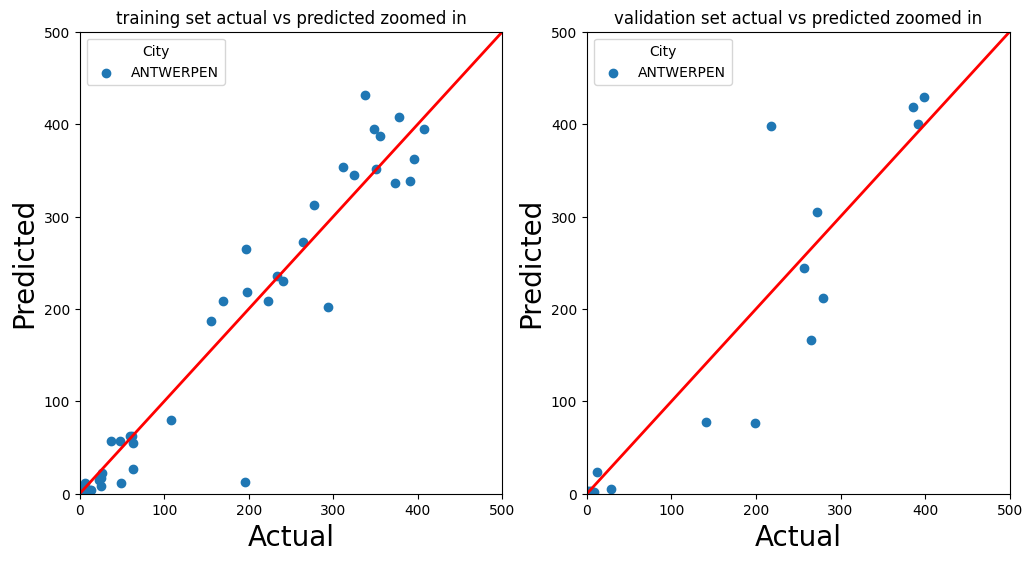

In [30]:
# Scatter plots with colors based on city
plt.figure(figsize=(12, 6))


#training plot

cities = X_train_with_all_columns['city'].unique()
city_to_color = {city: plt.cm.tab20(i) for i, city in enumerate(cities)}  # Using tab20 colormap for distinct colors

plt.subplot(1, 2, 1)
y_train_cities = []        # Store the results per city so that they can be used later
y_pred_train_cities = []   # Store the results per city so that they can be used later
cities_train = cities.copy()    # Store the cities so that the order is known

for city in cities:
    mask = X_train_with_all_columns['city'] == city
    y_train_city = y_train[mask.to_numpy()]
    y_pred_train_city = y_pred_train[mask.to_numpy()]
    y_train_cities.append(y_train_city)
    y_pred_train_cities.append(y_pred_train_city)
    plt.scatter(y_train_city, y_pred_train_city, label=city, color=city_to_color[city])

plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color="r", linestyle="-", linewidth=2)
plt.title("training set actual vs predicted zoomed in")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.xlim(0, 500)  # Set x-axis limit
plt.ylim(0, 500)  # Set y-axis limit
plt.legend(title='City', loc='upper left')


#validation plot
plt.subplot(1, 2, 2)
y_val_cities = []
y_pred_val_city = []
cities_val = cities.copy()

for city in cities:
    mask = X_val_with_all_columns['city'] == city
    y_val_city = y_val[mask.to_numpy()]
    y_pred_val_city = y_pred_val[mask.to_numpy()]
    y_val_cities.append(y_val_city)
    y_pred_val_city.append(y_pred_val_city )
    plt.scatter(y_val_city, y_pred_val_city, label=city, color=city_to_color[city])

plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="r", linestyle="-", linewidth=2)
plt.title("validation set actual vs predicted zoomed in")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.xlim(0, 500)  # Set x-axis limit
plt.ylim(0, 500)  # Set y-axis limit
plt.legend(title='City', loc='upper left')

plt.show()

## Metrics overview TRAIN

In [31]:
# The metrics for all the observations in the training data are calculated
df_metrics_overview_train = metrics_overview(y_train,y_pred_train[0], False)  # If you want to see the output here, change False to True

In [32]:
# Metrics overview per city
dfs_metrics_overview_train_cities = [df_metrics_overview_train]  # Is used to store all the information of the metrics of the training data

# The metrics per city in the training data are calculated
for city, y_train_city, y_pred_train_city in zip(cities_train, y_train_cities, y_pred_train_cities):
    df_metrics_overview_train_city = metrics_overview(y_train_city, y_pred_train_city[0], False)   # If you want to see the output here, change False to True
    dfs_metrics_overview_train_cities.append(df_metrics_overview_train_city)

In [33]:
# Write the results of the metrics to excel
name_tables = ['ALL TOGHETER'] + list(cities_train)
name_excel_file = name_excel_file_metrics + '_TRAIN.xlsx'
write_metrics_overviews_to_excel(name_excel_file, 'TRAIN', dfs_metrics_overview_train_cities, name_tables)

## Model on test data

The following part will use the trained model to predict the number of trips in the test set. The graphs below show similar behaviour as in the training set. Here, the underestimation for values above 1500 is visible again. 

production


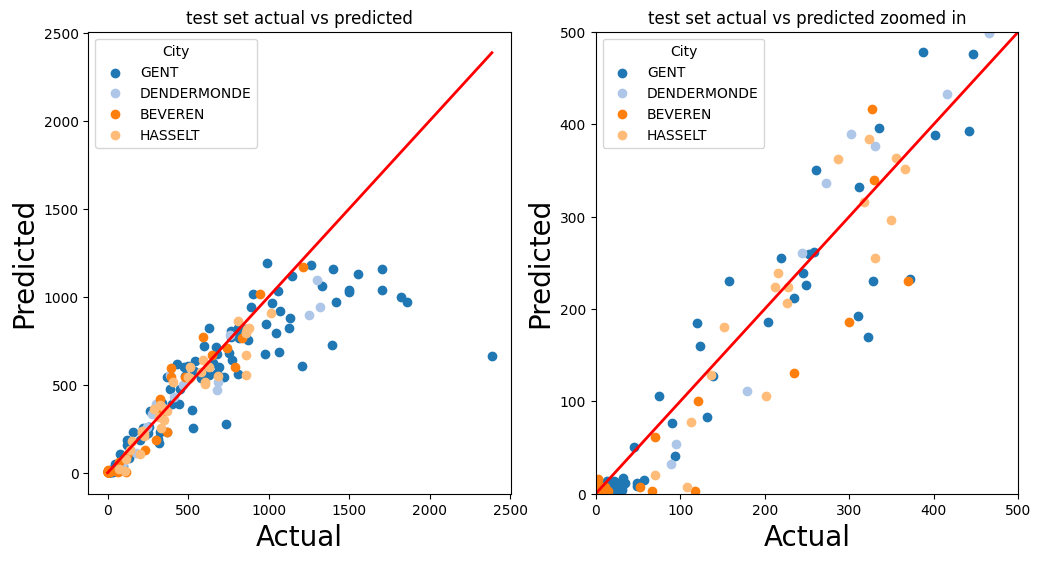

In [34]:
print(setup_params['target'])

model = xgb.XGBRegressor()
model.load_model(name_model) #If you have the trained model saved as a .json file, you can immediatly load it in here and make predictions on the test set. 

# get predictions on validation set
y_pred_test = pd.DataFrame(model.predict(X_test))

#Backtransform
if setup_params['logtrans'] == 1:
    X_test = X_test.apply(lambda x: np.exp(x)-1)  # Adding 1 to avoid log(0)
    y_pred_test = y_pred_test.apply(lambda x: np.exp(x)-1)
else:
    print("no log transfromation has been done")
    

#test plot
cities = X_test_with_all_columns['city'].unique()
city_to_color = {city: plt.cm.tab20(i) for i, city in enumerate(cities)}  # Using tab20 colormap for distinct colors
plt.figure(figsize = (12,6))
plt.subplot(1, 2, 1)
y_test_cities = []              # Store the results per city so that they can be used later
y_pred_test_cities = []         # Store the results per city so that they can be used later
cities_test = cities.copy()     # Store the cities so that the order is known


for city in cities:
    mask = X_test_with_all_columns['city'] == city
    y_test_city = y_test[mask.to_numpy()]
    y_pred_test_city = y_pred_test[mask.to_numpy()]
    y_test_cities.append(y_test_city)
    y_pred_test_cities.append(y_pred_test_city)
    plt.scatter(y_test_city, y_pred_test_city, label=city, color=city_to_color[city])

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="r", linestyle="-", linewidth=2)
plt.title("test set actual vs predicted")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.legend(title='City', loc='upper left')

plt.subplot(1, 2, 2)
for city in cities:
    mask = X_test_with_all_columns['city'] == city
    y_test_city = y_test[mask.to_numpy()]
    y_pred_test_city = y_pred_test[mask.to_numpy()]
    plt.scatter(y_test_city, y_pred_test_city, label=city, color=city_to_color[city])

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="r", linestyle="-", linewidth=2)
plt.title("test set actual vs predicted zoomed in")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.xlim(0, 500)  # Set x-axis limit
plt.ylim(0, 500)  # Set y-axis limit
plt.legend(title='City', loc='upper left')

plt.show()

## Metrics overview TEST

In [35]:
# The metrics for all the observations in the test data are calculated

df_metrics_test = metrics_overview(y_test,y_pred_test[0], False)    # If you want to see the output here, change False to True

In [36]:
# Metrics overview per city

dfs_metrics_overview_test_cities = [df_metrics_test] # Is used to store all the information of the metrics of the training data

# The metrics per city in the training data are calculated
for city, y_test_city, y_pred_test_city in zip(cities_test, y_test_cities, y_pred_test_cities):
    df_metrics_overview_test_city = metrics_overview(y_test_city, y_pred_test_city[0], False)   # If you want to see the output here, change False to True
    dfs_metrics_overview_test_cities.append(df_metrics_overview_test_city)

divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide


In [37]:
# Write the results to excel
name_tables = ['ALL TOGHETER'] + list(cities_test)
name_excel_file = name_excel_file_metrics + '_TEST.xlsx'
write_metrics_overviews_to_excel(name_excel_file, 'TEST', dfs_metrics_overview_test_cities, name_tables)

# Interpretation of the results

Discussions of the results will be limited and very similar to the full model in the following parts. These plots and interpretations are created to support the discussions of the research questions. 

## SHAP

The interpretation starts with an analysis of the shapley values. The shapley values of the test set will be used. However the code can also handle the training set.

In [38]:
# Specify which model and which datasets of points you want to analyse with the SHAP values
X_shap = X_test  # X_val, ...

explainer = shap.Explainer(model)
shap_values = explainer(X_shap)

print(setup_params['target'])
print(explainer.expected_value)

production
5.2517333


### Summary plot

In a summary plot, features are ranked according to their average absolute SHAP value. This indicates how much each feature contributes to a prediction.

So Inhabitant is the most import feature for the production model. All the other features have almost no impact compared to the inhabitant feature. The two biggest contributors are all 'population' features. This is logical as most trips produced between 7 and 8 am will be from places were people live as they leave their house to go work etc. 

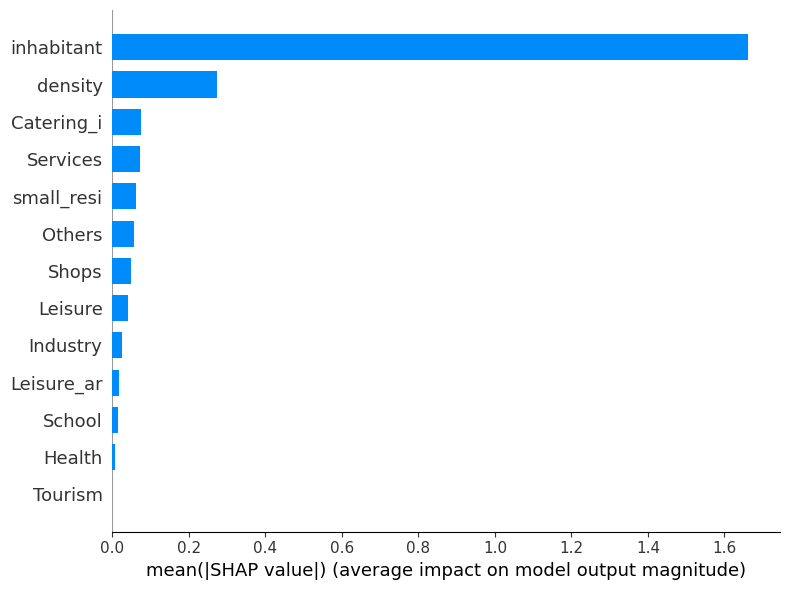

In [39]:
shap.summary_plot(shap_values, X_shap, plot_type="bar", plot_size=[8,6])

### Beeswarm plot

In contrast to the mean value in the summary plot, the beeswarm plots the values of the shap values of each observation for each feature. Moreover, the colour indicates the value for that particular feature for the observation.

The inhabitant feature either has a very positive or very negative impact on the SHAP value. A high value will always have a siginificant positive impact. Other features show similar behaviour but the impact is always small. 

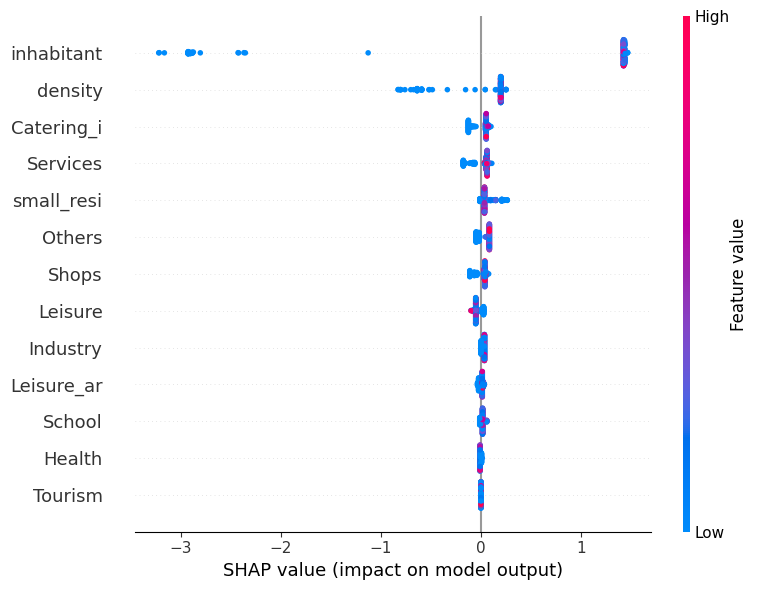

In [40]:
shap.summary_plot(shap_values, X_shap, plot_size=[8,6])

## Calculation absolute difference and percentage error per zone

In the following part the absolute difference and the percentage error between the real and the predicted values is calculated. Based on these values plots are made. Later these values will be used to analyze over and  underestimation. 

In [41]:
interest = 'test'  # 'train' is cities of the train data set, 'test' is the cities of the test dataset (has to be the same as X_shap)
print(interest)

if interest == 'train':
    # zones_plot = zones_city[zones_city["NIS_GEM_L"].str.contains("ANTWERPEN")]
    data_plot = pd.concat([X_train_with_all_columns, X_val_with_all_columns], ignore_index=True)  # Add X_train & X_val togheter and use this files so that the order is the same as in the real_values list

    pred_values_list_train = y_pred_train[0].values.flatten().tolist()
    pred_values_list_val = y_pred_val[0].values.flatten().tolist()
    pred_values_list = pred_values_list_train + pred_values_list_val
    real_values_list_train = y_train.tolist()
    real_values_list_val = y_val.tolist()
    real_values_list = real_values_list_train + real_values_list_val

elif interest == 'test':
    # zones_plot = zones_city[zones_city["NIS_GEM_L"].str.contains("GENT")]
    data_plot = data_test.copy()

    pred_values_list = y_pred_test.values.flatten().tolist()
    real_values_list = list(y_test)  

test


In [42]:
# Make the list with the difference between the predicted value and the 'real' value
result_difference = [x - y for x, y in zip(pred_values_list, real_values_list)]
percentage_error = [((x - y)/(y+1))*100 for x, y in zip(pred_values_list, real_values_list)]    # +1 so that there is no division by zero

## Plots

These plots are made per city:
- Attraction: values from attraction from the MOW, so not the model
- Absolute difference: absolute difference of outcome model vs values from MOW data
- Percentage difference: percentage difference of outcome model vs values from MOW data
- Filtered percentage difference: only the percentage difference that have an absolute difference bigger than the printed threshold


The colour bar of the absolute and percentage differences are fixed between [-100; 100] and [-500; 500], respectively. If the number of a zone is higher than the interval, the zone is coloured black and if it is lower than the interval, it is coloured yellow. A symmetrical interval is imposed so that the colours follow the intuition of white is neutral, red is negative and blue is positive. Working with fixed values for all cities ensures that cities can be easily compared with each other as this way the same colour means the same difference in each city. In addition, a very important reason for imposing these intervals is that if this is not done, little difference in colour can be observed. This is because in most cities there are a few extreme outliers. 

Cities are from:  test
Threshold for absolute value by filtering:  100
GENT


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


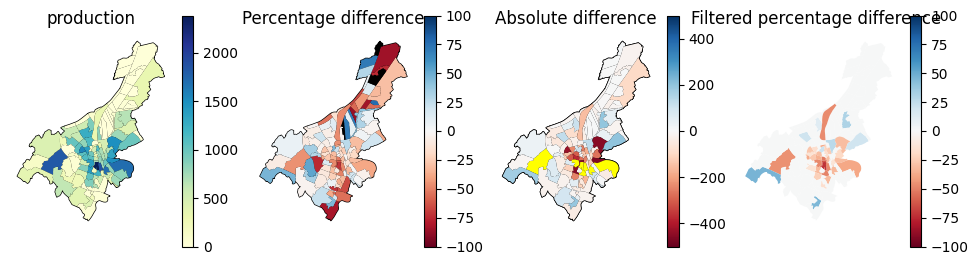

DENDERMONDE


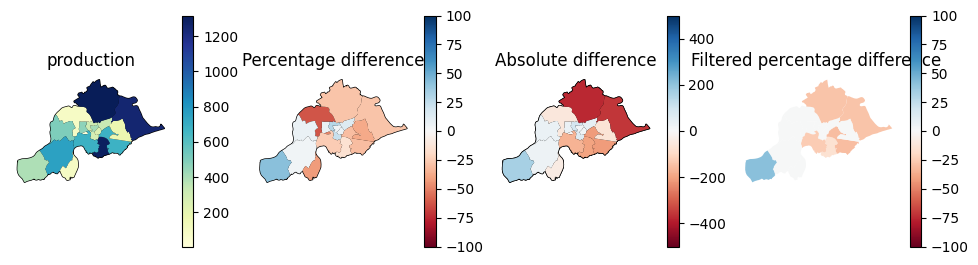

BEVEREN


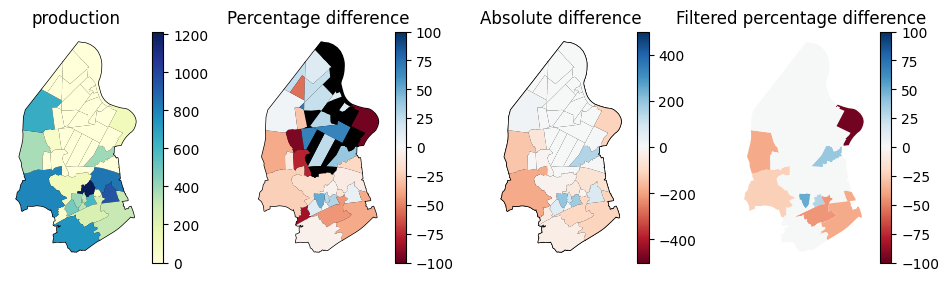

HASSELT


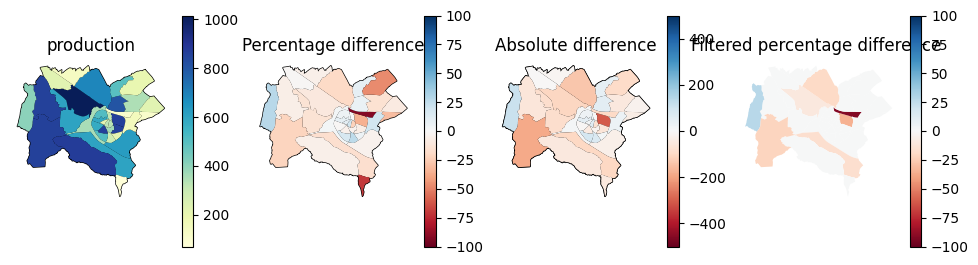

In [43]:
print('Cities are from: ', interest) 

threshold_filtering_absolute_value = 100  # Threshold 

print('Threshold for absolute value by filtering: ',threshold_filtering_absolute_value)

cities = data_plot['city'].unique()

cmap_adapted = plt.cm.get_cmap('RdBu')
cmap_adapted.set_over('black')  # Values above vmax (see later in subplot) will be plotted in black
cmap_adapted.set_under('yellow')  # Values below vmin (see later in subplot) will be plotted in yellow


# Iterate over each city and plot
for city in cities:
    print(city)
    city_data = data_plot[data_plot['city'] == city]

    # Extract the indices for the current city data
    indices = city_data.index

    # Create a filtering for the percentages with a min difference of absolute values
    adapted_percentages = []
    for i in indices:
        if abs(result_difference[i]) > threshold_filtering_absolute_value:
            adapted_percentages.append(percentage_error[i]) 
        else:
            adapted_percentages.append(0)  # So that this does not get a colour if the absolute difference is lower than the threshold

    fig, axes = plt.subplots(1, 4, figsize=(12, 3))

    # Plot the GeoPandas DataFrame for the current city in all subplots
    city_data.plot(ax=axes[0], color='lightgray', edgecolor='black')
    city_data.plot(ax=axes[1], color='lightgray', edgecolor='black')
    city_data.plot(ax=axes[2], color='lightgray', edgecolor='black')
    city_data.plot(ax=axes[2], color='lightgray', edgecolor='black')

    # Plot the values for attraction
    city_data.assign(values=data_plot[setup_params['target']]).plot(
        column='values', cmap='YlGnBu', linewidth=0, legend=True, ax=axes[0])
    axes[0].set_title(setup_params['target'])
    axes[0].set_axis_off()  # Remove the axes because these are the coordinates and does not provide added value

    # Plot the percentage difference 
    city_data.assign(values=[percentage_error[i] for i in indices]).plot(
        column='values', cmap= cmap_adapted, linewidth=0, legend=True, ax=axes[1], vmin = - 100, vmax = 100)
    axes[1].set_title(f'Percentage difference')
    axes[1].set_axis_off()  # Remove the axes because these are the coordinates and does not provide added value
    
    # Plot the absolute difference
    city_data.assign(values=[result_difference[i] for i in indices]).plot(
        column='values', cmap=cmap_adapted, linewidth=0, legend=True, ax=axes[2], vmin = - 500, vmax = 500)
    axes[2].set_title(f'Absolute difference')
    axes[2].set_axis_off()  # Remove the axes because these are the coordinates and does not provide added value

    # Plot the percentage difference where the condition is met
    city_data.assign(values=adapted_percentages).plot(
        column='values', cmap= cmap_adapted, linewidth=0, legend=True, ax=axes[3], vmin = - 100, vmax = 100)
    axes[3].set_title(f'Filtered percentage difference ')
    axes[3].set_axis_off()  # Remove the axes because these are the coordinates and does not provide added value
    

    # Show the plot
    plt.show()

The City of Beveren shows why a filtered percentage difference plot is also made. As can be seen, in the unfiltered plot, a large proportion of the zones are coloured black (i.e. more than 100% difference). Most of these black zones have a low production value (port area), resulting in such large percentages. As a result, most of the zones have been filtered out because the absolute difference does not exceed 100, and as a result, in the filtered percentage difference plot, there are not many black zones left.

In the plots above, it's clear that smaller cities have less errors. The worst estimates are all in the city of Gent. Most of these bad estimates are in the very center, close to the historical part of the city. 

These plots show the same behaviour as the full model.

## Underestimation

The following part checks why some of the instances are underestimated. A zone is greatly underestimated when the percentage error is lower than -75%. In total 10 zones are underestimated.  


In [44]:
#Underestimation 
indices = [index for index, value in enumerate(percentage_error) if (value <= -75)]
print(interest)
shap.initjs()

for indx in indices:
    zone_nr = data_plot.iloc[indx]['ZONENUMMER']
    print('\nZone number:', zone_nr)
    print("     Predicted value: ", pred_values_list[indx])
    print("     Real value: ", real_values_list[indx])
    print("     percentage error: ", percentage_error[indx])

    if interest == 'test':
        index = data_test.index[data_test['ZONENUMMER'] == zone_nr]
        print(data_test[data_test["ZONENUMMER"] == zone_nr].head())
        display(shap.force_plot(explainer.expected_value, shap_values.values[index,:], X_shap.iloc[index,:]))

    elif interest == 'train':
        index = data_train.index[data_train['ZONENUMMER'] == zone_nr]
        print(data_train[data_train["ZONENUMMER"] == zone_nr])
        display(shap.force_plot(explainer.expected_value, shap_values.values[index,:], X_shap.iloc[index,:]))

        
print("number of hits: ", len(indices))
## ATTRACTION
# zone 2500/2505/2507/2550 : Low inhabitants cause underestimation
# zone 2525/2531: high real value but no POI's and no inhabitants, No POI's actually decrease the prediction, this was not necessary here
# zone 2577: No POI's actually decrease the prediction, this was not necessary here
# Also remarkable that all of these are from Gent and not from the smaller cities

## PRODUCTION
# Almost everything here depends on the nr of inhabitants: if this doenst correspond than the prediction is bad
# interesting relation between density and inhabitants


test



Zone number: 2486
     Predicted value:  11.260125160217285
     Real value:  48.346999999999994
     percentage error:  -75.15527760508787
   ZONENUMMER  inhabitant    density  city  city_size  production  attraction  \
19       2486   107.25387  51.912073  GENT     270000      48.347     106.347   

    large_resi   small_resi  School  Health       Leisure       Shops  \
19         0.0  5840.240772     0.0     0.0  53943.654883  521.697612   

       Services     Industry   Catering_i      Tourism  Others    Leisure_ar  \
19  3150.190004  2109.476539  1620.202974  3929.651148     0.0  1.336151e+06   

                                             geometry  
19  POLYGON ((102591.073 193885.880, 102586.432 19...  



Zone number: 2520
     Predicted value:  4.033228874206543
     Real value:  30.976000000000006
     percentage error:  -84.25935428381742
   ZONENUMMER  inhabitant   density  city  city_size  production  attraction  \
53       2520    0.147875  0.174431  GENT     270000      30.976     339.978   

    large_resi  small_resi  School  Health  Leisure  Shops     Services  \
53         0.0         0.0     0.0     0.0      0.0    0.0  1921.396313   

         Industry  Catering_i  Tourism  Others  Leisure_ar  \
53  294888.747891  145.610865      0.0     0.0         0.0   

                                             geometry  
53  POLYGON ((108895.956 200918.701, 108255.699 20...  



Zone number: 2525
     Predicted value:  2.4218461513519287
     Real value:  25.0
     percentage error:  -86.83905326403104
   ZONENUMMER  inhabitant  density  city  city_size  production  attraction  \
58       2525         0.0      0.0  GENT     270000        25.0     780.999   

    large_resi  small_resi  School  Health  Leisure  Shops  Services  \
58         0.0         0.0     0.0     0.0      0.0    0.0       0.0   

    Industry  Catering_i  Tourism  Others  Leisure_ar  \
58       0.0         0.0      0.0     0.0         0.0   

                                             geometry  
58  POLYGON ((106355.784 200453.284, 106360.153 20...  



Zone number: 2531
     Predicted value:  1.8926377296447754
     Real value:  17.638
     percentage error:  -84.47989199675516
   ZONENUMMER  inhabitant   density  city  city_size  production  attraction  \
64       2531    0.732283  0.104383  GENT     270000      17.638     525.638   

    large_resi  small_resi  School  Health  Leisure  Shops  Services  \
64         0.0         0.0     0.0     0.0      0.0    0.0       0.0   

    Industry  Catering_i  Tourism  Others  Leisure_ar  \
64       0.0         0.0      0.0     0.0         0.0   

                                             geometry  
64  POLYGON ((109072.236 204556.156, 109049.418 20...  



Zone number: 2552
     Predicted value:  7.839682579040527
     Real value:  48.969
     percentage error:  -82.30966683535686
   ZONENUMMER  inhabitant     density  city  city_size  production  \
85       2552  331.191219  119.541185  GENT     270000      48.969   

    attraction  large_resi    small_resi  School  Health      Leisure  Shops  \
85      12.968         0.0  27006.628459     0.0     0.0  1291.732811    0.0   

    Services    Industry  Catering_i  Tourism  Others     Leisure_ar  \
85       0.0  146.332598   27.724837      0.0     0.0  200354.217857   

                                             geometry  
85  POLYGON ((102429.418 187473.943, 102407.245 18...  



Zone number: 2731
     Predicted value:  7.120092391967773
     Real value:  52.872
     percentage error:  -84.92706342447325
    ZONENUMMER  inhabitant     density     city  city_size  production  \
142       2731  251.219357  197.615123  BEVEREN      50000      52.872   

     attraction  large_resi    small_resi  School  Health     Leisure  \
142     147.871         0.0  19136.808704     0.0     0.0  242.674172   

           Shops  Services       Industry  Catering_i      Tourism  Others  \
142  7253.810901       0.0  110797.920037         0.0  2954.721377     0.0   

       Leisure_ar                                           geometry  
142  41785.901173  POLYGON ((139724.206 210919.236, 139747.410 21...  



Zone number: 2736
     Predicted value:  2.669738292694092
     Real value:  14.999
     percentage error:  -77.06270208954253
    ZONENUMMER  inhabitant  density     city  city_size  production  \
147       2736         0.0      0.0  BEVEREN      50000      14.999   

     attraction  large_resi   small_resi  School  Health  Leisure  Shops  \
147     156.998         0.0  1399.310732     0.0     0.0      0.0    0.0   

     Services       Industry  Catering_i  Tourism  Others  Leisure_ar  \
147       0.0  424323.109163         0.0      0.0     0.0         0.0   

                                              geometry  
147  POLYGON ((138289.638 216078.495, 138302.311 21...  



Zone number: 2737
     Predicted value:  2.7693943977355957
     Real value:  66.322
     percentage error:  -94.4009470934678
    ZONENUMMER  inhabitant   density     city  city_size  production  \
148       2737    9.682047  3.370586  BEVEREN      50000      66.322   

     attraction  large_resi  small_resi  School  Health     Leisure  Shops  \
148     104.323         0.0  162.586329     0.0     0.0  184.342913    0.0   

     Services       Industry  Catering_i  Tourism  Others  Leisure_ar  \
148       0.0  140116.044333         0.0      0.0     0.0         0.0   

                                              geometry  
148  POLYGON ((137846.359 217118.085, 137575.398 21...  



Zone number: 2762
     Predicted value:  3.4357872009277344
     Real value:  117.07900000000001
     percentage error:  -96.24337333401559
    ZONENUMMER  inhabitant  density     city  city_size  production  \
173       2762         0.0      0.0  BEVEREN      50000     117.079   

     attraction  large_resi  small_resi  School  Health  Leisure  Shops  \
173     209.076         0.0   11.446822     0.0     0.0      0.0    0.0   

        Services       Industry  Catering_i  Tourism  Others  Leisure_ar  \
173  6894.998432  569756.798439         0.0      0.0     0.0         0.0   

                                              geometry  
173  POLYGON ((143965.400 220647.039, 144045.454 22...  



Zone number: 2930
     Predicted value:  7.798066139221191
     Real value:  107.81700000000001
     percentage error:  -91.91480546309751
    ZONENUMMER  inhabitant    density     city  city_size  production  \
187       2930   33.812938  35.253211  HASSELT      80000     107.817   

     attraction  large_resi  small_resi      School  Health      Leisure  \
187     682.822         0.0  157.918905  7093.20012     0.0  3655.399734   

            Shops      Services       Industry   Catering_i      Tourism  \
187  13894.169284  11546.523839  142290.693978  1391.263033  4528.425061   

     Others    Leisure_ar                                           geometry  
187     0.0  11952.962963  POLYGON ((217776.866 182120.757, 217809.739 18...  


number of hits:  10


## Overestimation

For the large overestimate, the zones examined are those where at least three times overestimated (200%) and there is a minimum overestimate of an absolute value of 100. The condition for a minimum absolute value of 100 is because for small absolute numbers, a difference is immediately a large percentage difference. 

There are no zones with a considered big overestimation.

Overestimation doesn't seem to be a problem with the production model. The following instance is the greatest overestimation that happened. In the attraction model overestimation could go up to 200%, the highest for this test set is only 50%.

In [48]:
#Plot shapley values and force plots for overestimated instances
indices = [index for index, value in enumerate(percentage_error) if (value >= 80 and result_difference[index] > 100)]

print(interest)
shap.initjs()

for indx in indices:
    zone_nr = data_plot.iloc[indx]['ZONENUMMER']
    print('\nZone number:', zone_nr)
    print("     Predicted value: ", pred_values_list[indx])
    print("     Real value: ", real_values_list[indx])
    print("     percentage error: ", percentage_error[indx])

    if interest == 'test':
        index = data_test.index[data_test['ZONENUMMER'] == zone_nr]
        display(shap.force_plot(explainer.expected_value, shap_values.values[index,:], X_shap.iloc[index,:]))
        print(data_test[data_test["ZONENUMMER"] == zone_nr].head())

    elif interest == 'train':
        index = data_train.index[data_train['ZONENUMMER'] == zone_nr]
        display(shap.force_plot(explainer.expected_value, shap_values.values[index,:], X_shap.iloc[index,:]))
        print(data_train[data_train["ZONENUMMER"] == zone_nr])

        
print("number of hits: ", len(indices))
## PRODUCTION
# percentage error are much lower than attraction
# low production zones are mostly predicted pretty well (high percentage error but very low absolute difference)

test


number of hits:  0
